In [1]:
import numpy as np
from simulation.generate_path import generate_path
import matplotlib.pyplot as plt
from estimation.distance_sensor import distance_sensors
import random
import torch
import torch.nn as nn
import time
from estimation.kalman_filter_from_points_with_acc import kalman_filter_from_points_acc
from estimation.dual_iterative_non_iterative_estimator import iter_non_iter_estimator
import pickle

/home/user/miniconda3/envs/cuda_test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# create test data
target_initial_pos = np.array([0, 0, 5000])
target_speed_xy = 50
target_speed_z = 10
target_rot_speed = 3
time_res = 0.5

path1 = generate_path(0, target_speed_xy, target_speed_z, target_initial_pos, time_res)
path1.add_straight_interval(100)
path1.add_xy_turn_interval(90, -np.deg2rad(target_rot_speed))
path1.add_straight_interval(100)

# create noisy sensors
sensors = distance_sensors([[-5000,0,0],[ 400, -7400, 0],[ 800, 800, 0]], 15)
sensors.calculate_measurements(path1.path)
sigma_a = 1
sigma_v = 100
kf_acc = kalman_filter_from_points_acc(time_res, sigma_a, sigma_v, non_diag_reduction_ratio=2)
dual_est = iter_non_iter_estimator(sensors)
estimated_path = dual_est.estimate_path()
kf_path_acc = kf_acc.filter_path(estimated_path)

sample = 10
XTest = []
for i in np.arange(len(path1.path) - sample + 1):
    tmp = np.concatenate((sensors.sensor_locations, np.reshape(kf_path_acc[i,:], (1,3))), 0)
    tmp = tmp.reshape(4,3,1)
    for j in np.arange(1,sample):
        matrix = np.concatenate((sensors.sensor_locations, np.reshape(kf_path_acc[i+j,:], (1,3))), 0)
        matrix = matrix.reshape(4,3,1)
        tmp = np.concatenate((tmp, matrix),axis=2)
    if i > 0:
        tmp = tmp.reshape(4,3,sample,1)
        XTest = np.concatenate((XTest, tmp), 3)
    else:
        tmp = tmp.reshape(4,3,sample,1)
        XTest = tmp

YTest = path1.state_key[sample-1:]

print(np.shape(YTest))
print(np.shape(XTest))

(569, 1)
(4, 3, 10, 569)


In [3]:
XTrain = np.zeros((4,3,sample,0))
YTrain = np.zeros((0,1))

start_time = time.time()
for filename in [
    "../data/train_001.pkl",
    "../data/train_002.pkl",
    "../data/train_003.pkl",
    "../data/train_004.pkl",
    "../data/train_005.pkl",
    "../data/train_006.pkl",
]:
    print(f"loading file {filename}:", end =" ")
    mid_time = time.time()
    with open(filename, "rb") as f:
        train_data = pickle.load(f)
    print(f"{time.time() - mid_time} seconds")

    XTrain = np.concatenate((XTrain, np.concatenate((train_data["sensor_locations"], train_data["kf_estimate_path"]), axis=0)), axis=3)
    YTrain = np.concatenate((YTrain, train_data["state_key"]), axis=0)

print(f"total time: {time.time() - start_time} seconds")

print(np.shape(YTrain))
print(np.shape(XTrain))


loading file ../data/train_001.pkl: 0.0018019676208496094 seconds
loading file ../data/train_002.pkl: 0.07792997360229492 seconds
loading file ../data/train_003.pkl: 0.025696516036987305 seconds
loading file ../data/train_004.pkl: 0.7625594139099121 seconds
loading file ../data/train_005.pkl: 0.21699309349060059 seconds
loading file ../data/train_006.pkl: 0.4041709899902344 seconds
total time: 3.0417869091033936 seconds
(3803282, 1)
(4, 3, 10, 3803282)


In [4]:
# shuffle data
ind = np.arange(len(YTrain))
random.shuffle(ind)

XVal = torch.from_numpy(np.transpose(XTest, (3, 2, 0, 1)))
YVal = torch.from_numpy(YTest)

XTrain = torch.from_numpy(np.transpose(XTrain[:,:,:,ind], (3, 2, 0, 1)))
YTrain = torch.from_numpy(YTrain[ind,:])

In [5]:
def zero_location_to_end_point(data):
    # 256 10 4 3
    end_points = data[:,-1,3,:].reshape(data.shape[0],1,1,data.shape[3])
    end_points = np.repeat(end_points, data.shape[1], axis=1)
    end_points = np.concatenate((np.zeros((data.shape[0],10,data.shape[2]-1,data.shape[3])), end_points), axis=2)
    return data - end_points


In [6]:
# create network
class state_estimat(nn.Module):
    def __init__(self, d_in, num_classes):
        # initialzing the parent object (important!)
        super(state_estimat, self).__init__()
        # Create a pipeline - a sequence of layers
        
        self.pipe = torch.nn.Sequential(
            nn.Conv2d(d_in, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*3*4, 1))
            # nn.Linear(d_in*3*4, 1))
            # nn.Sigmoid())

        # self.d_in = d_in
        # self.device = device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


    def forward(self, x):
        # x = nn.Conv2d(self.d_in, 64, kernel_size=3, padding=1, device=self.device)(x)
        # x = nn.ReLU()(x)
        # x = nn.Conv2d(64, 64, kernel_size=3, padding=1, device=self.device)(x)
        # x = nn.ReLU()(x)
        # x = nn.Conv2d(64, 64, kernel_size=3, padding=1, device=self.device)(x)
        # x = nn.ReLU()(x)
        # x = nn.Flatten()(x)
        # x = nn.Linear(64*3*4, 1, device=self.device)(x)
        # return x
        return self.pipe(x)

In [7]:
# hyper-parameters:
# num_epochs = 100
num_epochs = 4
# batch_size = 512
batch_size = 512
learning_rate = 0.01
learning_rate_drop_period = 10
input_shape = [3,4,3]

# Device configuration, as before
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)
# create model
model = state_estimat(d_in=10, num_classes=1).to(device)
print(model)
# Loss and optimizer
# criterion = torch.nn.BCELoss()
# criterion = torch.nn.MSELoss()
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=learning_rate_drop_period, gamma=0.1)

cuda:0
state_estimat(
  (pipe): Sequential(
    (0): Conv2d(10, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=768, out_features=1, bias=True)
  )
)


In [8]:
# Train the model
total_step = len(YTrain)
start_time = time.time()
model = model.float()

loss_train = []
loss_val = []
loss_tmp = 0
norm = 1
for i in range(len(YVal)):
        # each i is a batch of 128 samples
        x, y = XVal[i,:,:,:], YVal[i,:]

        # x = x.unsqueeze(0).to(device)
        x = zero_location_to_end_point(x.unsqueeze(0)).to(device)
        y = y.unsqueeze(0).to(device)

        # Forward pass val
        outputs = model(x.float())
        # loss = criterion(nn.Sigmoid()(norm*outputs), norm*y.float().T)
        # loss = criterion(norm*outputs, norm*y.float().T)
        loss1 = criterion(norm*outputs, norm*y.float())
        loss2 = torch.mean(outputs**2 - y.float()**2)
        loss = loss1 + loss2
        
        loss_tmp += loss.item()
loss_val.append(loss_tmp/len(YVal))

for epoch in range(num_epochs):
    ind = np.arange(int(total_step/batch_size))
    random.shuffle(ind)
    for i,k in enumerate(ind):
        # each i is a batch of 128 samples
        x, y = XTrain[k*batch_size:(k+1)*batch_size,:,:,:], YTrain[k*batch_size:(k+1)*batch_size,:]

        # x = x.to(device)
        x = zero_location_to_end_point(x).to(device)
        y = y.to(device)

        # Forward pass
        outputs = model(x.float())
        # loss = criterion(norm*outputs, norm*y.float().T)
        # loss = criterion(nn.Sigmoid()(norm*outputs), norm*y.float())
        loss1 = criterion(norm*outputs, norm*y.float())
        loss2 = torch.mean(outputs**2 - y.float()**2)
        loss = loss1 + loss2
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_train.append(loss.item())

        if (i + 1) % 5== 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Time: {:.4f} secs, learning rate: {:.4f}'
                    .format(epoch + 1, num_epochs, i + 1, int(total_step/batch_size), loss.item(), time.time() - start_time, optimizer.param_groups[0]['lr']))

    loss_tmp = 0
    result = []
    for i in range(len(YVal)):
        # each i is a batch of 128 samples
        x, y = XVal[i,:,:,:], YVal[i,:]

        # x = x.unsqueeze(0).to(device)
        x = zero_location_to_end_point(x.unsqueeze(0)).to(device)
        y = y.unsqueeze(0).to(device)

        # Forward pass val
        outputs = model(x.float())
        # loss = criterion(norm*outputs, norm*y.float().T)
        # loss = criterion(nn.Sigmoid()(norm*outputs), norm*y.float().T)
        loss1 = criterion(norm*outputs, norm*y.float())
        loss2 = torch.mean(outputs**2 - y.float()**2)
        loss = loss1 + loss2
        
        loss_tmp += loss.item()
        # result.append(outputs[0,0].item())
        result.append(nn.Sigmoid()(outputs[0,0]).item())
    loss_val.append(loss_tmp/len(YVal))

    scheduler.step()

Epoch [1/4], Step [5/7428], Loss: 210280976.0000, Time: 1.3739 secs, learning rate: 0.0100
Epoch [1/4], Step [10/7428], Loss: 137721776.0000, Time: 1.3805 secs, learning rate: 0.0100
Epoch [1/4], Step [15/7428], Loss: 2422735616.0000, Time: 1.3869 secs, learning rate: 0.0100
Epoch [1/4], Step [20/7428], Loss: 1842972672.0000, Time: 1.3933 secs, learning rate: 0.0100
Epoch [1/4], Step [25/7428], Loss: 1100254592.0000, Time: 1.3996 secs, learning rate: 0.0100
Epoch [1/4], Step [30/7428], Loss: 447750240.0000, Time: 1.4060 secs, learning rate: 0.0100
Epoch [1/4], Step [35/7428], Loss: 120375140352.0000, Time: 1.4120 secs, learning rate: 0.0100
Epoch [1/4], Step [40/7428], Loss: 3063465472.0000, Time: 1.4177 secs, learning rate: 0.0100
Epoch [1/4], Step [45/7428], Loss: 4708014.5000, Time: 1.4234 secs, learning rate: 0.0100
Epoch [1/4], Step [50/7428], Loss: 1502572544.0000, Time: 1.4292 secs, learning rate: 0.0100
Epoch [1/4], Step [55/7428], Loss: 1512094.3750, Time: 1.4349 secs, learnin

(0.0, 1.0)

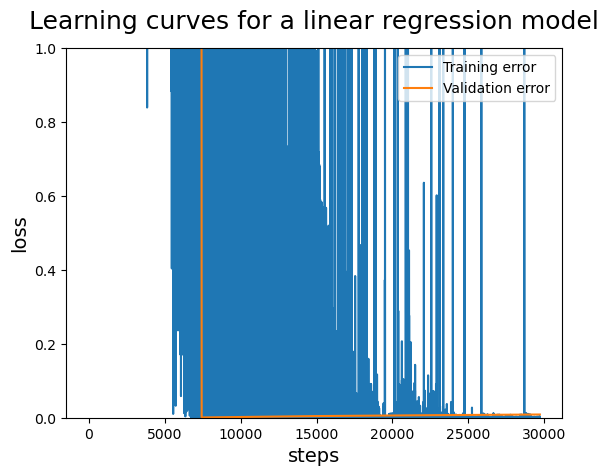

In [9]:
# plt.style.use('seaborn')
plt.plot(np.arange(len(loss_train)), loss_train, label = 'Training error')
plt.plot(np.arange(0, len(loss_train)+1, int(total_step/batch_size)), loss_val, label = 'Validation error')
plt.ylabel('loss', fontsize = 14)
plt.xlabel('steps', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim([0,1])

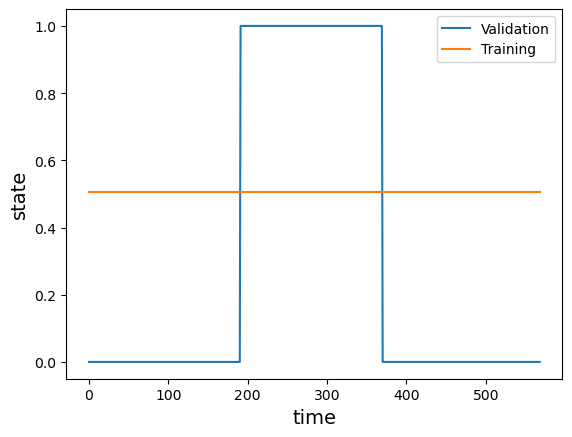

In [10]:
# plt.style.use('seaborn')
plt.plot(np.arange(len(result)), YVal, label = 'Validation')
plt.plot(np.arange(len(result)), result, label = 'Training')
plt.ylabel('state', fontsize = 14)
plt.xlabel('time', fontsize = 14)
plt.legend()
# plt.ylim([-0.5,3])